Have our own simple class to represent a note in time

In [1]:
import enum

class Note(enum.Enum):
    c = 0
    db = 1
    d = 2
    eb = 3
    e = 4
    f = 5
    gb = 6
    g = 7
    ab = 8
    a = 9
    bb = 10
    b = 11
    
    def __str__(self):
        if self == Note.c:
            return 'C'
        elif self == Note.db:
            return 'C#'
        elif self == Note.d:
            return 'D'
        elif self == Note.eb:
            return 'D#'
        elif self == Note.e:
            return 'E'
        elif self == Note.f:
            return 'F'
        elif self == Note.gb:
            return 'F#'
        elif self == Note.g:
            return 'G'
        elif self == Note.ab:
            return 'G#'
        elif self == Note.a:
            return 'A'
        elif self == Note.bb:
            return 'A#'
        elif self == Note.b:
            return 'B'

class NoteEvent:
    # Constructs event from midi.MidiEvent
    def __init__(self, midi_event, current_time):
        self.note = midi_event.note
        # In ticks
        self.start = midi_event.time + current_time
        self.end = None
    
    def is_valid(self):
        if self.note == None:
            return False
        if self.start == None or self.end == None:
            return False
        if self.end - self.start <= 0:
            return False
        return True
    
    def get_note(self):
        return Note(self.note % 12)
    
    def get_octave(self):
        return self.note // 12
    
    # position in the measure
    def get_beat(self, beats_per_measure):
        return self.start // beats_per_measure

    def __str__(self):
        return str(self.get_note()) + str(self.get_octave()) + ' ' + str(self.start) + '-' + str(self.end)

class NoteEventSequence:
    # Helper function
    def __finish_note(self, msg, current_time):
        for event in self.note_events:
            if event.end != None:
                continue
            if event.note != msg.note:
                continue
            event.end = msg.time + current_time
            break
    
    # Constructs sequence from mido.MidiTrack
    def __init__(self, midi_track):
        self.note_events = []
        self.beats_per_measure = None
        current_time = 0
        for msg in midi_track:
            if msg.type == 'note_on':
                self.note_events.append(NoteEvent(msg, current_time))
            elif msg.type == 'note_off':
                self.__finish_note(msg, current_time)
            elif msg.type == 'time_signature':
                self.beats_per_measure = msg.numerator
            current_time += msg.time
    
    def __str__(self):
        s = 'NoteEventSequence:\n\n'
        for note_event in self.note_events:
            s += '\t(' + str(note_event) + ')'
        return s + '\n'
    
    def is_empty(self):
        return len(self.note_events) == 0

    def remove_invalid(self):
        self.note_events = [note for note in self.note_events if note.is_valid()]

    def quantize(self, fraction, ticks_per_fraction):
        for note_event in self.note_events:
            note_event.start = int(round(note_event.start / ticks_per_fraction))
            note_event.end = int(round(note_event.end / ticks_per_fraction))
    
    # Probability of seeing each of the notes in the sequence
    def note_probabilities(self):
        counts = {}
        for note in Note:
            counts[note] = 0
        for note_event in self.note_events:
            counts[note_event.get_note()] += 1
        probabilities = []
        for note in Note:
            probabilities.append(counts[note] / len(self.note_events))
        return probabilities
    
    def is_monophonic(self):
        for note in self.note_events:
            for other_note in self.note_events:
                if note == other_note: continue
                if other_note.start > note.start and other_note.start < note.end:
                    return False
                elif other_note.end > note.start and other_note.end < note.end:
                    return False
        return True
        
class Composition:
    def __init__(self, midi_file):
        self.tracks = []
        self.ticks_per_beat = midi_file.ticks_per_beat
        self.beats_per_measure = 4 # a lot of midi files lack this and, let's face it, they're probably 4/4
        for track in midi_file.tracks:
            note_event_sequence = NoteEventSequence(track)
            note_event_sequence.remove_invalid()
            if note_event_sequence.beats_per_measure:
                self.beats_per_measure = note_event_sequence.beats_per_measure
            if not note_event_sequence.is_empty():
                self.tracks.append(note_event_sequence)
    
    def __str__(self):
        s = 'Composition: \n'
        s += '\tticks per beat: ' + str(self.ticks_per_beat) + '\n'
        s += '\tbeats per measure: ' + str(self.beats_per_measure) + '\n'
        for track in self.tracks:
            s += str(track) + '\n'
        return s

    # Quantize starts and ends to the nearest fraction beat (e.g., 8 to the nearest eights/quavers)
    def quantize(self, fraction):
        if self.beats_per_measure == None or self.ticks_per_beat == None:
            raise Exception('Invalid composition. Cannot quantize.')
        # Ticks per beat means ticks per quarter note (I think)
        ticks_per_fraction = 4 / fraction * self.ticks_per_beat
        for track in self.tracks:
            track.quantize(fraction, ticks_per_fraction)
    
    def monophonic_tracks(self):
        return [track for track in self.tracks if track.is_monophonic()]
    
    # Returns a tuple with (label, note) with label being cluster classification, then beat, then previous depth notes
    def correlations(self, depth, classifier):
        labels = []
        notes = []
        for track in self.monophonic_tracks():
            track_classification = classifier.predict([track.note_probabilities()])[0]
            for i, note in enumerate(track.note_events):
                if i < depth: continue
                label = [track_classification, note.get_beat(self.beats_per_measure)]
                label += [note.get_note().value for note in track.note_events[i-depth:i]]
                labels.append(label)
                notes.append(note.get_note().value)
        return labels, notes

We need to process each midi file. Which means loading the file, then for each track:

* Quantizing (quantize first in case the quantization process create unsuitable track)
* Discard from consideration if polyphonic
* Discard or sort separately if a simply classification algorithm (such as gaussiannb) determines it doesn't contain melodic information (drum part or too atonal to make sense of it)

In [2]:
import mido
import os
import re

midi_files = []
compositions = []

def process_midi_file(filen):
    midi_file = mido.MidiFile(filen)
    composition = Composition(midi_file)
    composition.quantize(8)
    compositions.append(composition)

midi_file_re = re.compile('.midi?$', re.IGNORECASE)

# Making it two separate loops to more easily be able to just do subsets of the data when testing
for root, dirs, files in os.walk('data/Metal_Rock_rock.freemidis.net_MIDIRip'):
    for file in files:
        if (midi_file_re.search(file)):
            midi_files.append(os.path.join(root, file))

# Loop separately so I can experiment with small subsets because holy crap is this a huge db
for midi_file in midi_files:#[:1000]:
    try:
        process_midi_file(midi_file)
    except Exception as e:
        pass # print(e) # this just gives us a bunch of errors from the invalid files in the lot


Now to train some models with the data

0.17708137826606443


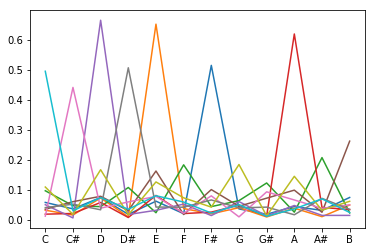

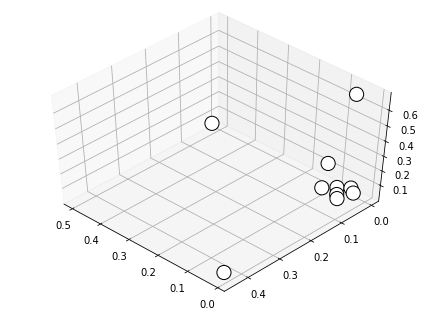

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn import metrics
%matplotlib inline

# To train a classifier with
note_probabilities = []

for composition in compositions:
    # get note probabilities 
    for track in composition.tracks:
        note_probabilities.append(track.note_probabilities())

# print(note_probabilities)

# for i in range(5,20):
#     kmeans_model = KMeans(n_clusters=i, random_state=1).fit(note_probabilities)
#     labels = kmeans_model.labels_
#     print(i)
#     print(metrics.silhouette_score(note_probabilities, labels, metric='euclidean')) # higher is better

kmeans_model = KMeans(n_clusters=10, random_state=1).fit(note_probabilities)
labels = kmeans_model.labels_
print(metrics.silhouette_score(note_probabilities, labels, metric='euclidean')) # higher is better

# print("Sample cluster: " + str(kmeans_model.predict([compositions[0].tracks[0].note_probabilities()])))

# Print to see if it looks like different modes/keys
note_names = [str(note) for note in Note]
for cluster_center in kmeans_model.cluster_centers_:
    plt.plot(cluster_center)
plt.xticks(np.arange(len(note_names)), [str(note) for note in Note])
plt.show()

fig = plt.figure()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(kmeans_model.cluster_centers_[:, 0], kmeans_model.cluster_centers_[:, 1], kmeans_model.cluster_centers_[:, 2], marker='o', c="white", alpha=1, s=200, edgecolor='k')

Now to train an SVM on the higher dimensions of previous notes, beat and entire composition classification

In [58]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

labels = []
notes = []

melodies = []

for composition in compositions[:1000]:
    composition_labels, composition_notes = composition.correlations(32, kmeans_model)
    monophonic_tracks = composition.monophonic_tracks()
    if len(monophonic_tracks) > 0:
        melodies.append((composition_labels, composition_notes, monophonic_tracks))
    labels += composition_labels
    notes += composition_notes

labels = Normalizer().transform(labels)

Now to actually train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(labels, notes, test_size=0.2, random_state=0)
    
monophonic_classifier = svm.LinearSVC()
monophonic_classifier.fit(X_train, y_train)
monophonic_classifier.score(X_test, y_test)

Now create a simple probabilistic note generator that simply generates new notes based on the relative frequencies of notes in the existing sequence. Then have both it and our schmancy model both generate measures of quarter notes and hope that for all this work, we're at least doing better than crude chance.

In [53]:
from sklearn.metrics import accuracy_score

class ProbabilityPredictor:
    def __init__(self, melodies):
        self.melodies = melodies
        self.notes = [note.value for note in Note]
    
    def score(self):
        y_true = []
        y_pred = []
        for composition_labels, composition_notes, melodies in self.melodies[:10]:
            for melody in melodies:
                probabilities = melody.note_probabilities()
                for note_event in melody.note_events:
                    y_true.append(note_event.get_note().value)
                    y_pred.append(np.random.choice(self.notes, p=probabilities))
        return accuracy_score(y_true, y_pred)

ProbabilityPredictor(melodies).score()


0.35485443202495454